In [72]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from data import create_data_for_lstm
import pandas as pd
import numpy as np
import statistics as st
from datetime import datetime

In [74]:
print("Am I using GPUS ???", torch.cuda.is_available())
print("Number of gpus: ", torch.cuda.device_count())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)
torch.manual_seed(101)

Am I using GPUS ??? True
Number of gpus:  1
cuda:0


In [75]:
# create LSTM Model
class SequenceDataset(Dataset):
    def __init__(
        self,
        dataframe,
        target,
        features,
        stations,
        sequence_length,
        forecast_hr,
        device,
    ):
        self.dataframe = dataframe
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.stations = stations
        self.forecast_hr = forecast_hr
        self.device = device
        self.y = torch.tensor(dataframe[target].values).float().to(device)
        self.X = torch.tensor(dataframe[features].values).float().to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
            x[: self.forecast_hr, -int(len(self.stations) * 15) :] = x[
                self.forecast_hr + 1, -int(len(self.stations) * 15) :
            ]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)
        return x, self.y[i]

In [76]:
station = "BKLN"
fh = 4
sequence_length = 120
batch_size = int(10e2)
(
    df_train,
    df_test,
    features,
    forecast_lead,
    stations,
    target,
) = create_data_for_lstm.create_data_for_model(station, fh)

Targeting Error for BKLN
-- loading data from NYSM --
-- loading data from HRRR --
now = 2024-01-19 19:17:40.252474
Test Set Fraction 0.20000445394619634
Data Processed


In [77]:
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    stations=stations,
    sequence_length=sequence_length,
    forecast_hr=fh,
    device=device,
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    stations=stations,
    sequence_length=sequence_length,
    forecast_hr=fh,
    device=device,
)

In [78]:
train_kwargs = {"batch_size": batch_size, "pin_memory": False, "shuffle": False}
test_kwargs = {"batch_size": batch_size, "pin_memory": False, "shuffle": False}

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [79]:
# class RNN_LSTM_Base(nn.Module):
#     def training_step(self, batch):
#         samples, targets = batch
#         outputs = self(samples.double())
#         loss = nn.functional.mse_loss(outputs, targets)
#         return loss


class VanillaRNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size, n_layers, device):
        super(VanillaRNN, self).__init__()
        # Define dimensions for the layers
        self.input_size = in_size
        self.hidden_size = hid_size
        self.output_size = out_size
        self.n_layers = n_layers
        self.device = device
        # Defining the RNN layer
        self.rnn = nn.RNN(in_size, hid_size, n_layers, batch_first=True)
        # Defining the linear layer
        self.linear = nn.Linear(hid_size, out_size)

    def forward(self, x):
        x.to(self.device)
        batch_size = x.shape[0]
        # x must be of shape (batch_size, seq_len, input_size)
        # xb = x.view(x.size(0), x.size(1), self.input_size).double()
        # Initialize the hidden layer's array of shape (n_layers*n_dirs, batch_size, hidden_size_rnn)
        h0 = torch.zeros(
            self.n_layers, batch_size, self.hidden_size, requires_grad=True
        ).to(self.device)
        # out is of shape (batch_size, seq_len, num_dirs*hidden_size_rnn)
        out, hn = self.rnn(x, h0)
        # out needs to be reshaped into dimensions (batch_size, hidden_size_lin)
        out = nn.functional.tanh(hn)
        # Finally we get out in the shape (batch_size, output_size)
        out = self.linear(out[0]).flatten()
        return out

In [80]:
def train_model(data_loader, model, loss_function, optimizer, device, epoch):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch_idx, (X, y) in enumerate(data_loader):
        # Move data and labels to the appropriate device (GPU/CPU).
        X, y = X.to(device), y.to(device)

        # Forward pass and loss computation.
        output = model(X)
        loss = loss_function(output, y)

        # Zero the gradients, backward pass, and optimization step.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the total loss and the number of processed samples.
        total_loss += loss.item()

    # Compute the average loss for the current epoch.
    avg_loss = total_loss / num_batches
    print("epoch", epoch, "train_loss:", avg_loss)

    return avg_loss


def test_model(data_loader, model, loss_function, device, epoch):
    # Test a deep learning model on a given dataset and compute the test loss.
    num_batches = len(data_loader)
    total_loss = 0

    # Set the model in evaluation mode (no gradient computation).
    model.eval()

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            # Move data and labels to the appropriate device (GPU/CPU).
            X, y = X.to(device), y.to(device)

            # Forward pass to obtain model predictions.
            output = model(X)

            # Compute loss and add it to the total loss.
            total_loss += loss_function(output, y).item()

        # Calculate the average test loss.
        avg_loss = total_loss / num_batches
        print("epoch", epoch, "test_loss:", avg_loss)

    return avg_loss

In [81]:
def predict(data_loader, model, device):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [82]:
def eval_model(
    train_dataset,
    df_train,
    df_test,
    test_dataset,
    model,
    batch_size,
    title,
    target,
    features,
    rank,
):
    train_eval_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False
    )
    test_eval_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    ystar_col = "Model forecast"
    df_train[ystar_col] = predict(train_eval_loader, model, rank).cpu().numpy()
    df_test[ystar_col] = predict(test_eval_loader, model, rank).cpu().numpy()

    df_out = pd.concat([df_train, df_test])[[target, ystar_col]]

    for c in df_out.columns:
        vals = df_out[c].values.tolist()
        mean = st.mean(vals)
        std = st.pstdev(vals)
        df_out[c] = df_out[c] * std + mean

    df_out["diff"] = df_out.iloc[:, 0] - df_out.iloc[:, 1]
    now = datetime.now()
    print("now =", now)
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%m_%d_%Y_%H:%M:%S")
    return df_out

In [83]:
in_size = 134
hid_size = 100
out_size = 1
n_layers = 3
learning_rate = 5e-3
weight_decay = 0.0
epochs = 5

In [84]:
init_start_event = torch.cuda.Event(enable_timing=True)
init_end_event = torch.cuda.Event(enable_timing=True)

model = VanillaRNN(
    in_size=in_size,
    hid_size=hid_size,
    out_size=out_size,
    n_layers=n_layers,
    device=device,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
loss_function = nn.MSELoss()


init_start_event.record()
train_loss_ls = []
test_loss_ls = []
for ix_epoch in range(1, epochs + 1):
    train_loss = train_model(
        train_loader, model, loss_function, optimizer, device, ix_epoch
    )

    test_loss = test_model(test_loader, model, loss_function, device, ix_epoch)
    print(" ")
    train_loss_ls.append(train_loss)
    test_loss_ls.append(test_loss)
    # log info for comet and loss curves
init_end_event.record()

epoch 1 train_loss: 0.5800922877258725
epoch 1 test_loss: 0.500701967212889
 
epoch 2 train_loss: 0.47476428167687523
epoch 2 test_loss: 0.38869359095891315
 
epoch 3 train_loss: 0.451575110356013
epoch 3 test_loss: 0.34344880614015794
 
epoch 4 train_loss: 0.4343077705966102
epoch 4 test_loss: 0.390778597858217
 
epoch 5 train_loss: 0.4756019711494446
epoch 5 test_loss: 0.3634265694353316
 


In [93]:
df_out = eval_model(
    train_dataset,
    df_train,
    df_test,
    test_dataset,
    model,
    batch_size,
    "Eval_model",
    target,
    features,
    device,
)

now = 2024-01-19 19:20:59.501480


In [100]:
df_out

,target_error_lead_0,Model forecast,diff
0,0.458820,-0.661771,1.120590
1,0.211947,-0.815267,1.027214
2,0.150498,-0.832870,0.983368
3,0.327624,-0.812405,1.140028
4,0.394973,-0.865905,1.260878
...,...,...,...
44899,-0.970480,-0.499299,-0.471181
44900,-0.580047,-0.592201,0.012154
44901,-0.972586,-0.777870,-0.194716
44902,-1.372019,-0.881174,-0.490845


In [104]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_plotly(df, title, target):
    df = df.sort_index()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(df[target], c="r", label="Target")
    plt.plot(df["Model forecast"], c="b", alpha=0.7, label="LSTM Output")
    plt.axvline(
        x=(int(0.2 * len(df["Model forecast"]))),
        c="black",
        linestyle="--",
        linewidth=2.0,
        label="Test Set Start",
    )
    ax.set_title(f"LSTM Output v Target -- {title}", fontsize=28)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023], fontsize=18)
    ax.set_xticks(
        np.arange(0, len(df["Model forecast"]), (len(df["Model forecast"]) / 6))
    )
    ax.legend()

/tmp/tmp.sjhtxMBVgt/ipykernel_3259138/3526506104.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023], fontsize=18)


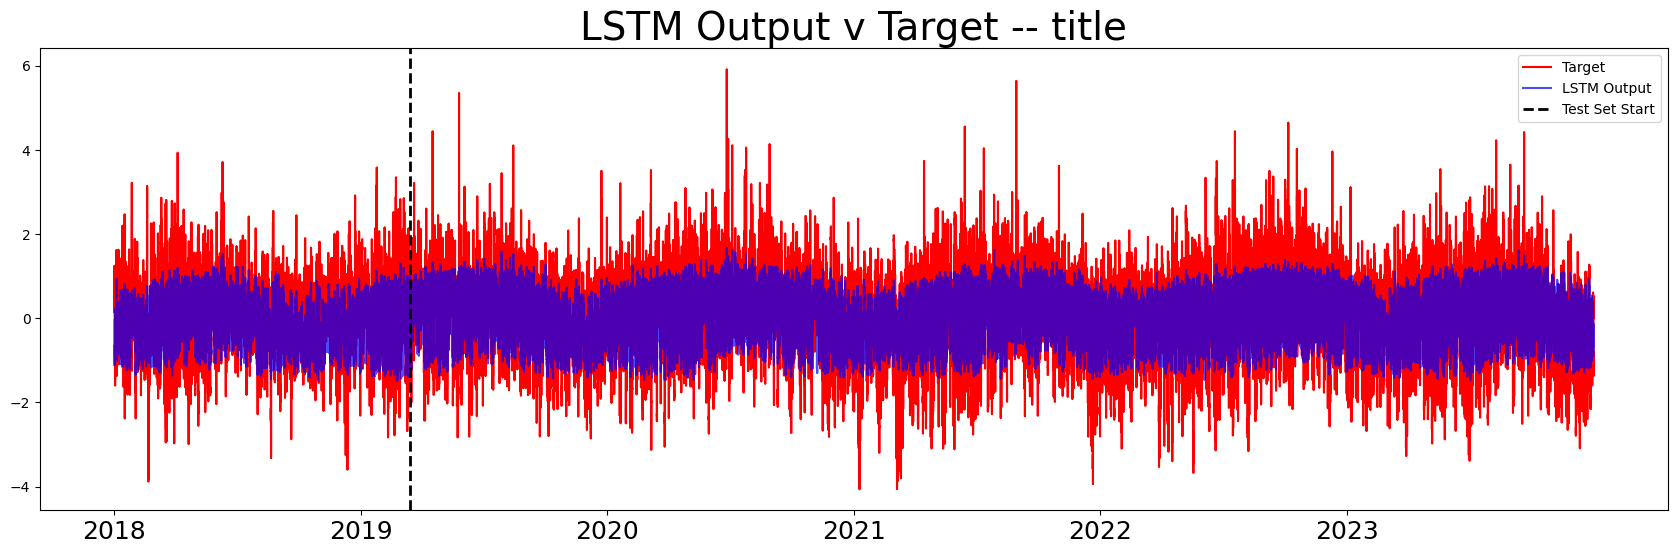

In [105]:
plot_plotly(df_out, "title", target)